In [1]:
import wfdb
import os
import pandas as pd
import wfdb.processing as wp
import numpy as np
import pickle
from biosppy.signals import ecg, tools

import torch
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torch import nn, optim

import pytorch_model_summary

from sklearn.preprocessing import MinMaxScaler as mms

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as patches
from matplotlib.patheffects import withStroke

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIbLE_DEVICES"] = "0"

In [2]:
# Data Extract From Physionet *.dat

input_path = "../physionet/mit-bih_arr/1.0.0/"
records = open(input_path+"RECORDS","r")
records_list = []
for l in records:
    l = l.rstrip()
    records_list.append(l)
records.close()
print(records_list)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']


In [3]:
NORMAL_ANN = ['N', 'L', 'R']
SUPRA_ANN = ['e',"j","A","a","J","S"]
VENTRI_ANN = ['V', 'E']
FUSION_ANN = ['F']
UNCLASS_ANN = ['/', 'f', 'Q']

In [4]:
window_size = 320

# Ref : Heartbeat classification fusing temporal and morphological information of ECGs via ensemble of classifiers
NORMAL_ANN = ['N', 'L', 'R']
SUPRA_ANN = ['e',"j","A","a","J","S"]
VENTRI_ANN = ['V', 'E']
FUSION_ANN = ['F']
UNCLASS_ANN = ['/', 'f', 'Q']

ANN_DICT = {0:"N", 1:"S", 2:"V", 3:"F", 4:"Q", 5:"-"}

def extract_from_sbj(idx, sampfrom, sampto):
    record_sig = wfdb.rdsamp(input_path+records_list[idx], channels=[0], sampfrom=sampfrom, sampto = sampto)
    record_ann = list(wfdb.rdann(input_path+records_list[idx],"atr",sampfrom=sampfrom, sampto = sampto).sample)[1:] # R Peak x_position
    record_ann_sym = list(wfdb.rdann(input_path+records_list[idx], "atr",sampfrom=sampfrom, sampto = sampto).symbol)[1:] # R Peak Symbol
    interval = wp.ann2rr(input_path+records_list[idx], 'atr', as_array=True)
    
    """
    0 : N | 1 : S | 2 : V | 3 : F | 4 : Q
    """
    for i,sym in enumerate(record_ann_sym):
        if sym in NORMAL_ANN:
            record_ann_sym[i] = 0
        elif sym in SUPRA_ANN:
            record_ann_sym[i] = 1
        elif sym in VENTRI_ANN:
            record_ann_sym[i] = 2
        elif sym in FUSION_ANN:
            record_ann_sym[i] = 3
        elif sym in UNCLASS_ANN:
            record_ann_sym[i] = 4
        else:
            record_ann_sym[i] = 5
    
#     zorder=2
#     def draw_circle_with_annotation(ax, position, label):
#         nonlocal zorder
#         point = patches.Circle(position, picker=True, edgecolor="r", zorder=zorder, radius=0.25, facecolor="none")
#         ax.add_patch(point)
#         zorder+=1
    return record_sig, record_ann, record_ann_sym
    
    
#     scaler.fit(record_sig)

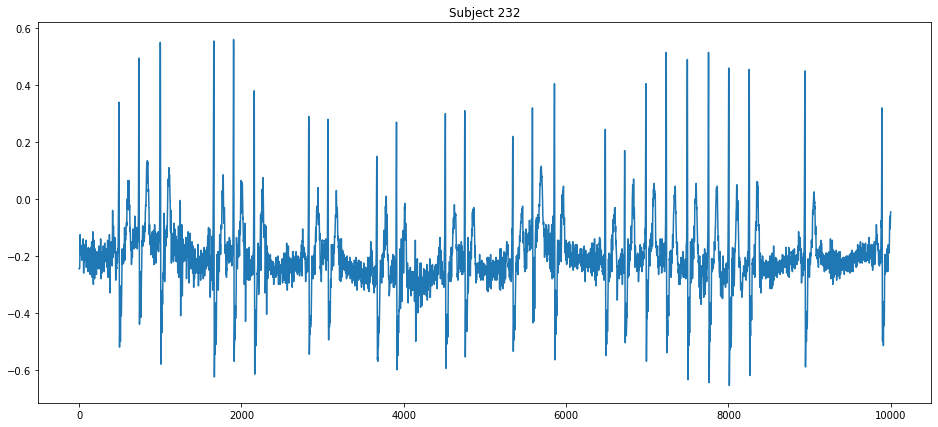

In [5]:
idx = 45
sampfrom= 0
sampto = 10000
record_sig, record_ann, record_ann_sym = extract_from_sbj(idx, sampfrom, sampto)
%matplotlib INLINE
fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title("Subject {}".format(records_list[idx]))
ax1.plot(record_sig[0][0:10000])
#     draw_circle_with_annotation(ax1, (record_ann[0],record_sig[0][record_ann[0]]), ANN_DICT[record_ann_sym[0]])
# ax1.annotate(text=ANN_DICT[record_ann_sym[0]], xy=(record_ann[0],record_sig[0][record_ann[0]]),fontsize=15,ha="center")
# ax1.annotate(text=ANN_DICT[record_ann_sym[1]], xy=(record_ann[1],record_sig[0][record_ann[1]]),fontsize=15,ha="center")
plt.show()

In [6]:
# Beat Segment (Visualization)

# Beat Segement Points = median(prev_Rpeak, now_Rpeak) ~ median(now_Rpeak, next_Rpeak)
seg_points = []

"""
첫 rpeak는 next_Rpeak랑만 계산
"""
l_ann = len(record_ann)
last_points = len(record_sig[0])-1

N_Sig = []
S_Sig = []
V_Sig = []
F_Sig = []
Q_Sig = []

for i in range(l_ann):
    
    now_r = record_ann[i]
    now_sym = (ANN_DICT[record_ann_sym[i]],record_ann_sym[i])
    if now_sym[0] == "-":
        continue
    if i == 0: # 첫번째 예외처리
        next_r = record_ann[i+1]
        next_points = (next_r + now_r) // 2
        prev_points = 0
    elif i == l_ann-1: #마지막 예외처리
        prev_r = record_ann[i-1]
        prev_points = (prev_r + now_r) // 2
        next_points = last_points
    else: 
        prev_r = record_ann[i-1]
        next_r = record_ann[i+1]

        prev_points = (prev_r+now_r)//2
        next_points = (next_r+now_r)//2
    
    
#     print(prev_points, next_points, "Size :", (next_points-prev_points), now_sym)
    # Beat Segmentation
    if now_sym[0] == "N":
        N_Sig.append([prev_points,next_points])
    elif now_sym[0] == "S":
        S_Sig.append([prev_points,next_points])  
    elif now_sym[0] == "V":
        V_Sig.append([prev_points,next_points])
    elif now_sym[0] == "F":
        F_Sig.append([prev_points,next_points])
    elif now_sym[0] == "Q":
        Q_Sig.append([prev_points,next_points])
    
    
    

<IPython.core.display.Javascript object>


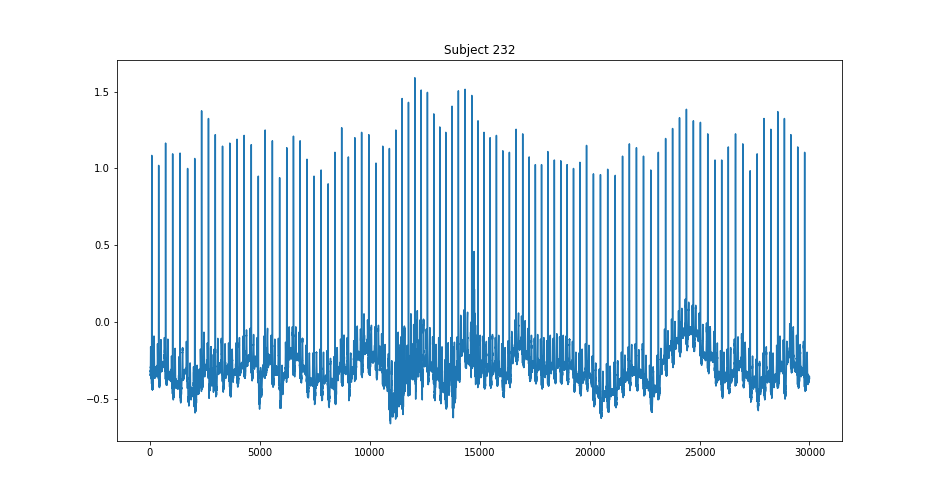

In [34]:
record_sig, record_ann, record_ann_sym = extract_from_sbj(1,0,250000)

%matplotlib notebook
fig = plt.figure(figsize=(13,7))
ax1 = fig.add_subplot(1,1,1)
ax1.set_title("Subject {}".format(records_list[idx]))
ax1.plot(record_sig[0][0:30000])
plt.show()

# Baseline Wander

Baseline이 위 plot을 보다시피 매우 일정하지않고 amplitude가 매우 왔다갔다한다. 이를 Baseline Wander라고 함  
이를 처리하기 위해서 여러가지 필터를 적용하여 Baseline wander를 제거해야한다



### ref : https://github.com/spebern/py-bwr

In [16]:
from pybwr import bwr
import numpy as np

In [26]:
np_sig = np.array(record_sig[0]).reshape(-1)

In [27]:
baseline = bwr.calc_baseline(np_sig)

In [28]:
baseline

array([-0.29714372, -0.29665236, -0.29615633, ..., -0.23244348,
       -0.23274333, -0.23304603])

In [37]:
ecg_out = np_sig - baseline

ecg_out_baseline = bwr.calc_baseline(ecg_out)

<IPython.core.display.Javascript object>


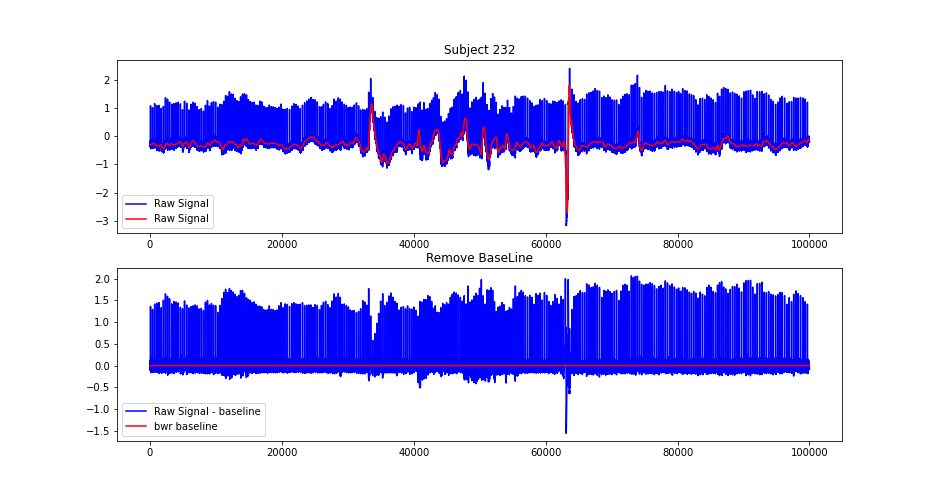

In [38]:
%matplotlib notebook
# fig = plt.figure(figsize=(13,7))
# plt.subplot(2, 1, 1)
# plt.plot(np_sig, "b-", label="Raw signal")
# plt.plot(baseline, "r-", label="baseline")
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(ecg_out, "b-", label="Raw signal - baseline")
# plt.legend()
# plt.show()


fig = plt.figure(figsize=(13,7))
ax1 = fig.add_subplot(2,1,1)
ax1.set_title("Subject {}".format(records_list[idx]))
ax1.plot(np_sig[0:100000],"-b", label="Raw Signal")
ax1.plot(baseline[0:100000],"r-", label="Raw Signal")
ax1.legend()

ax2 = fig.add_subplot(2,1,2)
ax2.set_title("Remove BaseLine")
ax2.plot(ecg_out[0:100000], "b-", label="Raw Signal - baseline")
ax2.legend()

plt.show()

### Ref : https://github.com/sharewithmyx/ECGdenosing/blob/master/baselineRemoval.py

In [56]:
import numpy as np
from scipy.signal import butter,lfilter, freqz
from scipy.signal import medfilt

def fix_baseline_wander(data, fs=360): #two median Filter
    data = np.array(data)
    winsize = int(round(0.2*fs))
    
    if winsize%2==0:
        winsize+=1
    
    baseline_estimate = medfilt(data, kernel_size=winsize)
    winsize = int(round(0.6*fs))
    
    if winsize%2==0:
        winsize+=1
        
    baseline_estimate = medfilt(baseline_estimate, kernel_size=winsize)
    ecg_blr = data - baseline_estimate
    return ecg_blr.tolist(), baseline_estimate.tolist()

In [57]:
ecg_blr, baseline = fix_baseline_wander(np_sig)

<IPython.core.display.Javascript object>


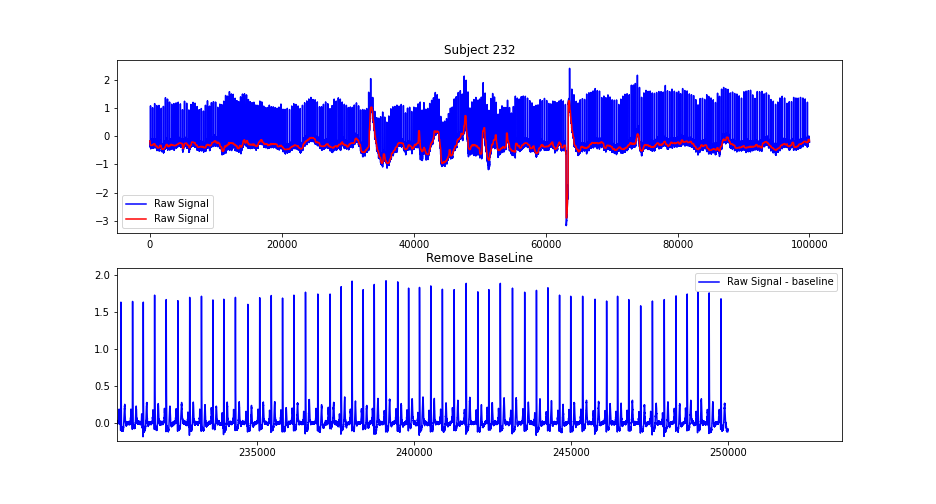

In [59]:
%matplotlib notebook
fig = plt.figure(figsize=(13,7))
ax1 = fig.add_subplot(2,1,1)
ax1.set_title("Subject {}".format(records_list[idx]))
ax1.plot(np_sig[0:100000],"-b", label="Raw Signal")
ax1.plot(baseline[0:100000],"r-", label="Raw Signal")
ax1.legend()

ax2 = fig.add_subplot(2,1,2)
ax2.set_title("Remove BaseLine")
ax2.plot(ecg_blr[0:650000], "b-", label="Raw Signal - baseline")
ax2.legend()

plt.show()